# gp.Latent

The `gp.Latent` class is a direct implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

Concretely, what this means is that with some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  Some sample code is,

    import numpy as np
    import pymc3 as pm

    # A one dimensional column vector of inputs.
    X = np.linspace(0, 1, 10)[:,None]
    
    with pm.Model() as latent_gp_model:
        # Specify the covariance function.
        cov_func = pm.gp.cov.ExpQuad(1, lengthscales=0.1)
        
        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Latent(cov_func=cov_func)
        
        # Place a GP prior over the function f.
        f = gp.prior("f", n_points=10, X=X)
        
By default, PyMC3 reparameterizes the prior on `f` by rotating it with the Cholesky factor.  This helps to reduce covariances in the posterior of the transformed GP, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

For more information about this reparameterization, see the secion on [drawing values from a multivariate distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution).  This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## `.conditional`

The conditional method implements the "predictive" distribution for function values that were not necessarily part of the data set.  This distribution is,

$$
\mathbf{f}_* \mid \mathbf{f} \sim \text{MvNormal} \left(
  \mathbf{m}_* + \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1} \mathbf{f} ,\,
  \mathbf{K}_{**} - \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1}\mathbf{K}_{x*} \right)
$$

In PyMC3, using the same `gp` that we defined above, this is specified as,

    # vector of new X points we want to predict the function at
    X_star = np.linspace(0, 2, 100)[:, None]

    with latent_gp_model:
        f_star = gp.conditional("f_star", n_points=100, X_star)
        
By default, the `gp` object keeps track of `f` and `X` to condition on.  This can be overridden by providing different values as optional keyword arguments,

        f_star_diff = gp.conditional("f_star_diff", n_points=100, X_star, 
                                     X=X_diff, f=f_diff)
                                     
No changes need to be made to how `conditional` is called depending on the value of the `reparameterize` flag in the `prior` method.   

## Working example

The following is an example showing how to specify a simple model with a GP prior using the `gp.Latent` class.  So we can verify that the inference we perform is correct, the data set is made using a draw from a GP.  

In [1]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

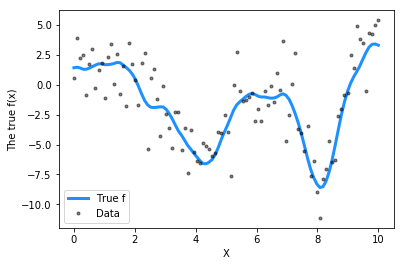

In [2]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
plt.xlabel("X"); plt.ylabel("The true f(x)"); plt.legend();

The data above shows the observations, marked with black dots, of the unknown function $f(x)$ that has been corrupted by some IID normal noise.  The true function is in blue.  

## Coding the model in PyMC3

Here's the model in PyMC3.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(5)$ priors over the covariance function scale, and noise scale.  Then, a GP prior is placed on the unknown function.  For more information on choosing priors in Gaussian process models, check out some of [recommendations by the Stan folks](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", n_points=n, X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = pm.Normal("y", mu=f, sd=σ, observed=y)
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 261.21:   9%|▊         | 17299/200000 [01:04<16:30, 184.37it/s]
Convergence archived at 17300
Interrupted at 17,300 [8%]: Average Loss = 294.23
100%|██████████| 1500/1500 [03:29<00:00,  6.96it/s]/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:463: UserWarning: Chain 0 contains 14 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



## Results

Below are the posteriors of the covariance function hyperparameters.  The red lines show the true values that were used to draw the function from the GP.

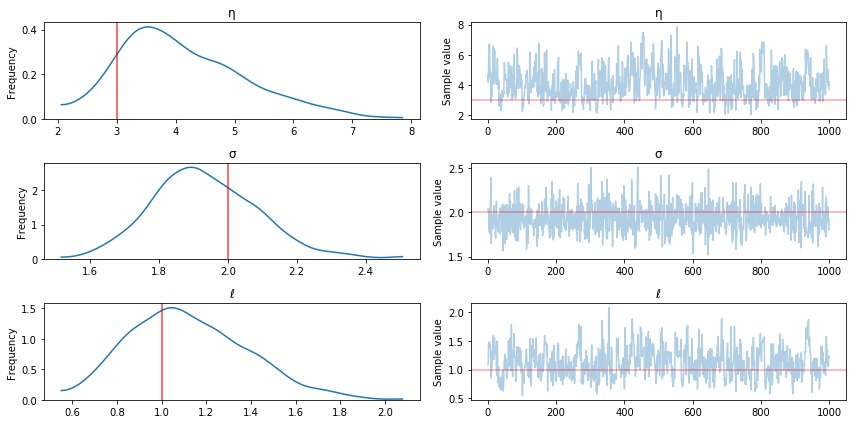

In [4]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true}, varnames=["η", "σ", "ℓ"]);

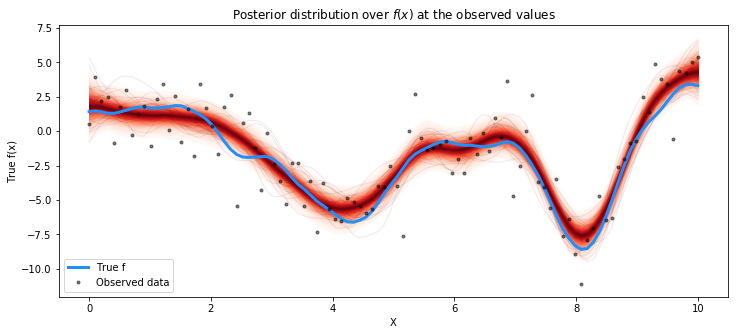

In [5]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace, X, varname="f");

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit and the uncertainty caused by the additive noise. 

## Prediction

Next, we extend the model by adding the conditional distribution so we can predict at new $x$ locations.  Lets see how the extrapolation out to higher $x$ looks.  To do this, we extend our `model` with the `conditional` distribution of the GP.  Then, we can sample from it using our `trace` and the `sample_ppc` function.  This is similar to how Stan uses its `generated quantities {...}` blocks.  We could have included `gp.conditional` in the model *before* we did the NUTS sampling, but it is more efficient to perform 

In [6]:
# 200 new values from x=0 to x=20
n_new = 200
X_new = np.linspace(0, 20, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", n_new, X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_ppc(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:18<00:00, 53.56it/s]


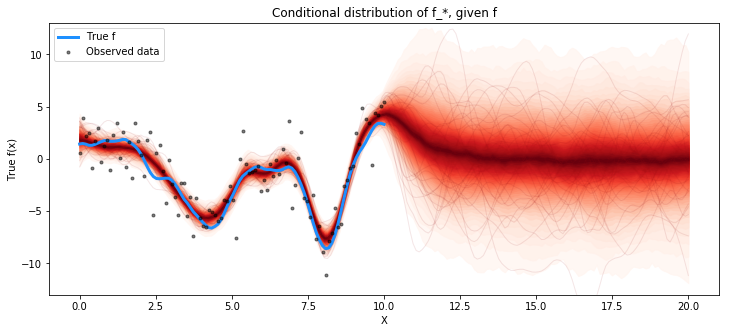

In [7]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples, X_new, "f_pred");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)"); plt.ylim([-13,13]);
plt.title("Conditional distribution of f_*, given f"); plt.legend();